In [1]:
import numpy as np
from scipy.stats import ttest_rel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

log_dir = "/Users/jrudoler/Library/CloudStorage/Box-Box/JR_CML/pytorch_logs/"

In [15]:
precond = pd.read_csv(
    "/Users/jrudoler/Library/CloudStorage/Box-Box/JR_CML/pytorch_logs/precond_results_LTP093_20230426-204534.csv"
)
precond["model"] = "precond"
logreg = pd.read_csv(
    "/Users/jrudoler/Library/CloudStorage/Box-Box/JR_CML/pytorch_logs/logreg_results_LTP093_20230426-114900.csv"
)
logreg["model"] = "logreg"

<AxesSubplot:xlabel='session', ylabel='AUC/test'>

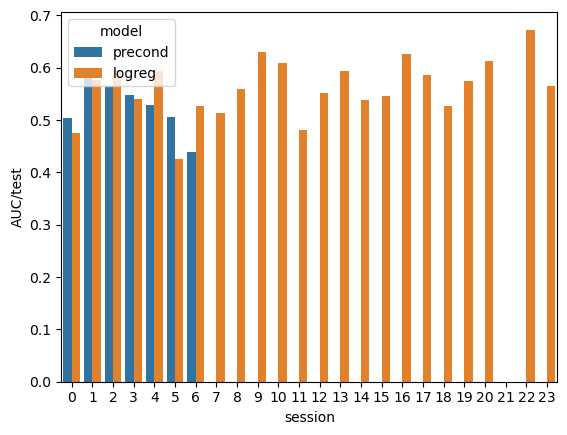

In [16]:
sns.barplot(
    data=pd.concat([precond, logreg]),
    x="session",
    y="AUC/test",
    hue="model",
)

In [17]:
ttest_rel(precond, logreg)

Ttest_relResult(statistic=-0.08497352741166442, pvalue=0.9331714352906815)

In [17]:
import os

In [20]:
files = os.listdir("/Users/jrudoler/data/scalp_features/class_1/")

In [23]:
np.unique([f[4:10] for f in files])

array(['LTP093'], dtype='<U6')